In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

In [19]:
#Read the data into dataframe
car_df = pd.read_csv('newCardata.csv')
car_features = pd.read_csv('finalDataPreprocessBinary.csv')
car_label = car_df['FraudFound']
new_syntheticData = pd.read_csv('MwMOTEgeneratedSyntheticData.csv')


In [20]:
#change the label of the data
labelNo = LabelEncoder()
car_df['FraudFound'] = labelNo.fit_transform(car_df['FraudFound'].astype('str'))
car_label = car_df['FraudFound']
print(car_label.shape)


(15419,)


In [4]:
new_syntheticData.shape

(13573, 52)

In [5]:
#MwMote
combine_car_features = pd.read_csv('finalPreprocessBinaryTogether.csv')
combine_car_label = pd.read_csv('label.csv')
print(combine_car_features.shape)
print(combine_car_label.shape)

(28992, 52)
(28992, 1)


In [6]:
#add columns to existing dataframe
combine_car_features['FraudFound']=combine_car_label 

In [7]:
combine_car_features.head()

,Make_0,Make_1,Make_2,Make_3,Make_4,MaritalStatus_0,MaritalStatus_1,PolicyType_0,PolicyType_1,PolicyType_2,...,PoliceReportFiled_Yes,WitnessPresent_No,WitnessPresent_Yes,AgentType_External,AgentType_Internal,RepNumber,Deductible,DriverRating,DayDiff,FraudFound
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.733333,0.00,0.000000,0.000000,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0.933333,0.25,1.000000,0.013587,0
2,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0.400000,0.25,0.666667,0.035326,0
3,0,0,0,0,1,0,1,0,0,1,...,1,1,0,1,0,0.200000,0.25,0.333333,0.054348,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.133333,0.25,0.000000,0.040761,0


In [8]:
#shuffle the data.
new_combine_features = combine_car_features.set_index(np.random.permutation(combine_car_features.index))

In [9]:
#now divide the feature and label
new_label = new_combine_features['FraudFound']

#drop the Fraud Found lable
#drop the following attributes
new_combine_features.drop(['FraudFound'],inplace=True,axis=1)
# new_label.shape
# print(new_label)

In [10]:
#train the model
X_train,X_test,y_train,y_test = train_test_split(new_combine_features,new_label,random_state=3,test_size=0.25)

In [11]:
#model object
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

print('Random forest classifier:')
predicted = model.predict(X_test)
print(type(predicted),predicted.shape,predicted)
print('Accuracy is ',round(accuracy_score(y_test,model.predict(X_test)) * 100,2))


Random forest classifier:
<class 'numpy.ndarray'> (7248,) [1 1 0 ..., 0 0 1]
Accuracy is  99.41


In [12]:
y_test= pd.Series(y_test).values
print(type(y_test))
print(type(predicted))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [13]:
# calculating specifity and sensitivity
# 0  := Negative(FraudNotFound)
# 1 := Positive (FraudFound)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix:\n",cm)
TN, FP, FN, TP = cm.ravel()

print("TN:",TN)
print("FP:",FP)
print("FN:",FN)
print("TP:",TP)

print("Accuracy:",(TP+TN)/(TP+FP+FN+TN)*100)
print("Sensitivity:",TP/(TP+FN)*100)
print("Specificity:",TN/(TN+FP)*100)

Confusion Matrix:
 [[3580   43]
 [   0 3625]]
TN: 3580
FP: 43
FN: 0
TP: 3625
Accuracy: 99.4067328918
Sensitivity: 100.0
Specificity: 98.8131382832


In [104]:
#cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = model_selection.KFold(n_splits=10, random_state=10)
model=RandomForestClassifier(n_estimators=100) 

results = model_selection.cross_validate(estimator=model,X=new_combine_features,y=new_label,cv=kfold,scoring=scoring)

print(np.mean(results['test_accuracy']))
print(np.mean(results['test_precision']))
print(np.mean(results['test_recall']))
print(np.mean(results['test_f1_score']))


0.995999333896
0.945712857552
0.997811358373
0.970128952268


In [105]:
# Run classifier with cross-validation and plot ROC curves
from sklearn.model_selection import StratifiedKFold
from scipy import interp


cv = StratifiedKFold(n_splits=10)
classifier = RandomForestClassifier(n_estimators=100) 
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
print("Features shape",new_combine_features.shape)
print("Label shape",new_label.shape)

new_combine_features= pd.DataFrame(new_combine_features).values
new_label= pd.Series(new_label).values
print(type(new_label))
print(type(new_combine_features))

Features shape (28992, 52)
Label shape (28992,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [106]:
#plot of ROC curve for cross validation
accuracy= []
precision= []
sensitivity= []
specificity= []
f1score= []

for train, test in cv.split(new_combine_features, new_label):
    
          
    probas_ = classifier.fit(new_combine_features[train], new_label[train]).predict_proba(new_combine_features[test])
    j= 0
    for j in range(probas_.shape[0]):
        if (probas_[j,1]>0.5):
            probas_[j,1]= 1
        else:
            probas_[j,1]= 0

      
    cm = confusion_matrix(new_label[test],probas_[:,1])
    TN, FP, FN, TP = cm.ravel()
    acc= (TP+TN)/(TP+FP+FN+TN)*100
    prec= TP/(TP+FP)*100
    sens= TP/(TP+FN)*100
    spec= TN/(TN+FP)*100
    f1= (2 * prec * sens)/(prec + sens)
    
    accuracy.append(acc)
    precision.append(prec)
    sensitivity.append(sens)
    specificity.append(spec)
    f1score.append(f1)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(new_label[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1



In [107]:
print("Accuracy:",np.mean(accuracy))
print("Precision:",np.mean(precision))
print("Sensitivity:",np.mean(sensitivity))
print("Specificity:",np.mean(specificity))
print("F1_score:",np.mean(f1score))


Accuracy: 99.6447252564
Precision: 99.321886962
Sensitivity: 99.9724137931
Specificity: 99.3170367197
F1_score: 99.6459756971


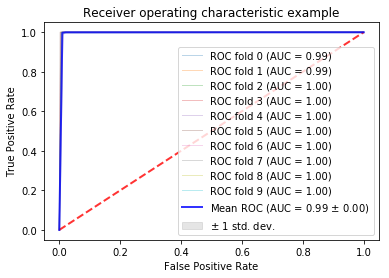

In [108]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
          alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [53]:
print(car_features.shape)
print(car_label.shape)

(28992, 52)
(15419,)


In [58]:
#random forest without smote with cross validation
cv = StratifiedKFold(n_splits=10)
classifier = RandomForestClassifier(n_estimators=100) 
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
accuracy= []
precision= []
sensitivity= []
specificity= []
f1score= []

car_features= pd.DataFrame(car_features).values
car_label= pd.Series(car_label).values



for train, test in cv.split(car_features, car_label):
    probas_ = classifier.fit(car_features[train], car_label[train]).predict_proba(car_features[test])
    j= 0
    for j in range(probas_.shape[0]):
        if (probas_[j,1]>0.5):
            probas_[j,1]= 1
        else:
            probas_[j,1]= 0

      
    cm = confusion_matrix(car_label[test],probas_[:,1])
    TN, FP, FN, TP = cm.ravel()
    acc= (TP+TN)/(TP+FP+FN+TN)*100
    prec= TP/(TP+FP)*100
    sens= TP/(TP+FN)*100
    spec= TN/(TN+FP)*100
    f1= (2 * prec * sens)/(prec + sens)
    
    accuracy.append(acc)
    precision.append(prec)
    sensitivity.append(sens)
    specificity.append(spec)
    f1score.append(f1)
    
print("Accuracy:",np.mean(accuracy))
print("Precision:",np.mean(precision))
print("Sensitivity:",np.mean(sensitivity))
print("Specificity:",np.mean(specificity))
print("F1_score:",np.mean(f1score))

Accuracy: 94.091695325
Precision: 66.5
Sensitivity: 2.49064983637
Specificity: 99.9241093739
F1_score: 4.78194876928


In [21]:
#own kfold cross validation
from sklearn.model_selection import KFold 


#add two np array in x-direction
print(new_combine_features.shape)
print(new_label.shape)
X= new_combine_features
print(X.shape)
print(new_label.shape)
print(type(X))
print(type(new_label))

X= X.values
new_label= new_label.values

classifier = RandomForestClassifier(n_estimators=100) 

#kf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=None) 
kf = KFold(n_splits=10,random_state=False,shuffle=False)

accuracy= []
precision= []
sensitivity= []
specificity= []
f1score= []


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = new_label[train_index], new_label[test_index]
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    j= 0
    for j in range(probas_.shape[0]):
        if (probas_[j,1]>0.5):
            probas_[j,1]= 1
        else:
            probas_[j,1]= 0

      
    cm = confusion_matrix(y_test,probas_[:,1])
    if(cm.shape[0]==1):
        print("y_test label:",y_test[0],y_test[1])
        zrow= np.zeros((1,2),dtype=int)
        zcol= np.zeros((1,1),dtype=int)
        cm= np.concatenate((cm,zcol),axis=1)
        cm= np.concatenate((cm,zrow),axis=0)
    print(cm)
    print(type(cm))
    print("shape",cm.shape)
    TN, FP, FN, TP = cm.ravel()
    acc= (TP+TN)/(TP+FP+FN+TN)*100
    prec= TP/(TP+FP)*100
    sens= TP/(TP+FN)*100
    spec= TN/(TN+FP)*100
    f1= (2 * prec * sens)/(prec + sens)
    
    accuracy.append(acc)
    precision.append(prec)
    sensitivity.append(sens)
    specificity.append(spec)
    f1score.append(f1)
    
    

(28992, 52)
(28992,)
(28992, 52)
(28992,)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [22]:
print("Accuracy:",np.mean(accuracy))
print("Precision:",np.mean(precision))
print("Sensitivity:",np.mean(sensitivity))
print("Specificity:",np.mean(specificity))
print("F1_score:",np.mean(f1score))

Accuracy: nan
Precision: nan
Sensitivity: nan
Specificity: nan
F1_score: nan


/usr/local/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
